<a href="https://colab.research.google.com/github/gilbert83416/NTUST-AI-Master-degree-Reference/blob/main/Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 掛接雲端硬碟
# 根目錄（'/content/drive/MyDrive/python/train.zip'） 相對（'drive/MyDrive/python/train.zip'）
import zipfile
path = '/content/drive/MyDrive/python/train.zip'
f = zipfile.ZipFile(path)
f.extractall()


In [ ]:
import glob
glob.glob('train/*')

['train/dog.8583.jpg',
 'train/cat.2392.jpg',
 'train/dog.3491.jpg',
 'train/cat.5043.jpg',
 'train/cat.4225.jpg',
 'train/dog.1382.jpg',
 'train/dog.2551.jpg',
 'train/cat.5181.jpg',
 'train/cat.4228.jpg',
 'train/dog.10178.jpg',
 'train/dog.7147.jpg',
 'train/cat.5976.jpg',
 'train/cat.11646.jpg',
 'train/cat.2996.jpg',
 'train/cat.4509.jpg',
 'train/dog.3987.jpg',
 'train/cat.11656.jpg',
 'train/cat.6664.jpg',
 'train/dog.9985.jpg',
 'train/cat.11650.jpg',
 'train/cat.600.jpg',
 'train/cat.8708.jpg',
 'train/dog.12028.jpg',
 'train/dog.1349.jpg',
 'train/cat.8966.jpg',
 'train/cat.11629.jpg',
 'train/dog.4324.jpg',
 'train/dog.12314.jpg',
 'train/cat.7152.jpg',
 'train/cat.5761.jpg',
 'train/cat.3238.jpg',
 'train/cat.6031.jpg',
 'train/cat.4898.jpg',
 'train/cat.8451.jpg',
 'train/cat.1956.jpg',
 'train/dog.3210.jpg',
 'train/dog.3892.jpg',
 'train/dog.369.jpg',
 'train/dog.2789.jpg',
 'train/dog.2259.jpg',
 'train/dog.1546.jpg',
 'train/cat.893.jpg',
 'train/cat.1859.jpg',
 'train

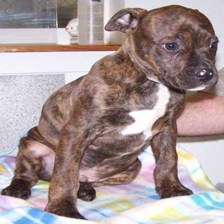

In [ ]:
# read img (2 method: PIL/Tensorflow load img)
# 尺寸要跟當初source 差不多, Convert("RGB")怕灰階有問題
from PIL import Image
fs = glob.glob('train/*')
Image.open(fs[6]).resize((224,224)).convert("RGB")


In [ ]:
# stole model : keras application('https://keras.io/api/applications/')
# download and check the image size(69KB * 25000/ 1000 =~ 1G 耗RAM 要小心)
import pandas as pd
dog = glob.glob('train/dog.*')
cat = glob.glob('train/cat.*')

datas = pd.DataFrame({
    'path': dog + cat,
    'ans': [0] * len(dog) + [1]* len(cat)
})
datas

,path,ans
0,train/dog.8583.jpg,0
1,train/dog.3491.jpg,0
2,train/dog.1382.jpg,0
3,train/dog.2551.jpg,0
4,train/dog.10178.jpg,0
...,...,...
24995,train/cat.11015.jpg,1
24996,train/cat.11721.jpg,1
24997,train/cat.4982.jpg,1
24998,train/cat.11511.jpg,1


tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [ ]:
# Create model: Kearas Application VGG16 : stole Weight
# 下游任務BERT（Bidirectional Encoder Representations from Transformers）

from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
# weak classification: 前面分的好(CNN 參數用的好)後面MLP Dense 參數就可少 128之類的
# Dense(2,activation = 'softmax')(1,activation = 'sigmoid')
# Trainable params: 可作梯度下降 , non-trainable: Freeze , trainable(只跑MLP)

# Total params: 17,926,338
# Trainable params: 3,211,650
# Non-trainable params: 14,714,688) original parameter
 
# new normalization: 2048 = 512 mu + 512 sigma +  512 new mu + 512 new sigma
# (Ori mu and sigma)1024 :non-trainable (New nu and sigma) 1024: trainable to find optimized loss

from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
vgg_layers = vgg.layers
for l in vgg_layers:
  l.trainable = False

clf_layers = [
              BatchNormalization(),
              Flatten(),
              Dense(128, activation = 'relu'),
              Dropout(0.25),
              Dense(2, activation = 'softmax')
]
model =  Sequential(vgg_layers + clf_layers)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
# Sparse 就不用自己做one-hot
# VVG16 非tensorflow 所以不用/255 ,因為VVG16是 caffe (follow original source)已作處理
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(), 
       optimizer="adam",
       metrics=["accuracy"])

In [ ]:
# demo pre (preprocessing need to follow original source preprocessing)
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(fs[5000]).resize((224, 224)).convert("RGB")
img_np = np.array(img)
preprocess_input(img_np)

array([[[ -8.939003 , -17.779    , -23.68     ],
        [ -7.939003 , -16.779    , -22.68     ],
        [-12.939003 , -22.779    , -26.68     ],
        ...,
        [-46.939003 , -55.779    , -61.68     ],
        [-46.939003 , -55.779    , -61.68     ],
        [-47.939003 , -56.779    , -62.68     ]],

       [[-19.939003 , -28.779    , -34.68     ],
        [-11.939003 , -20.779    , -26.68     ],
        [ -4.939003 , -14.778999 , -18.68     ],
        ...,
        [-45.939003 , -54.779    , -60.68     ],
        [-45.939003 , -54.779    , -60.68     ],
        [-46.939003 , -55.779    , -61.68     ]],

       [[-25.939003 , -34.779    , -40.68     ],
        [ -9.939003 , -18.779    , -24.68     ],
        [ -2.939003 , -11.778999 , -16.68     ],
        ...,
        [-45.939003 , -54.779    , -60.68     ],
        [-45.939003 , -54.779    , -60.68     ],
        [-44.939003 , -53.779    , -59.68     ]],

       ...,

       [[ -5.939003 , -14.778999 , -16.68     ],
        [ -

In [ ]:
# example
# numpy.ranint exclusive, randomint inclusive
# 還沒讀圖不能直接使用fit (fit generator or / per batch validation (train on batch))
# 給群資料 回batch (多少張圖片gradiant descent)
# def get_data(x, y, batch = 20):

x, y = np.array(datas['path']), np.array(datas['ans'])

def get_data(x, y, batch = 20):
  idx = np.random.randint(0, len(x), size=batch)
  y_batch = y[idx]
  x_batch, x_batch_ori = [],[]
  for p in x[idx]:
    img = Image.open(p).resize((224, 224)).convert("RGB")
    img_np = np.array(img)
    img_np_pre = preprocess_input(img_np)
    x_batch.append(img_np_pre)
    x_batch_ori.append(img_np)
  return (np.array(x_batch), np.array(y_batch), np.array(x_batch_ori))
x_batch, y_batch, x_batch_ori = get_data(x, y)
print(x_batch.shape)
print(y_batch.shape)
print(x_batch_ori.shape)

(20, 224, 224, 3)
(20,)
(20, 224, 224, 3)


In [ ]:
# train_on_batch 單次梯度更新 test_on_batch 在一批樣本上測試模型
for i in range(20):
  print('-'*10, i, '-'*10)
  x_batch, y_batch, x_batch_ori = get_data(x, y)
  result = model.train_on_batch(x_batch, y_batch)
  print('[Train]:',result)
  x_batch, y_batch, x_batch_ori = get_data(x, y)
  result = model.test_on_batch(x_batch, y_batch)
  print('[Validate]:',result)



---------- 0 ----------
[Train]: [1.0722987651824951, 0.44999998807907104]
[Validate]: [20.66219711303711, 0.6000000238418579]
---------- 1 ----------
[Train]: [0.6751823425292969, 0.800000011920929]
[Validate]: [5.710598945617676, 0.8500000238418579]
---------- 2 ----------
[Train]: [0.4866968095302582, 0.8500000238418579]
[Validate]: [7.347634792327881, 0.800000011920929]
---------- 3 ----------
[Train]: [1.8529746532440186, 0.800000011920929]
[Validate]: [21.778528213500977, 0.550000011920929]
---------- 4 ----------
[Train]: [0.3440263271331787, 0.8999999761581421]
[Validate]: [22.472604751586914, 0.699999988079071]
---------- 5 ----------
[Train]: [0.13431432843208313, 0.949999988079071]
[Validate]: [18.16704559326172, 0.699999988079071]
---------- 6 ----------
[Train]: [0.67588210105896, 0.75]
[Validate]: [10.352462768554688, 0.8500000238418579]
---------- 7 ----------
[Train]: [0.4569846987724304, 0.8500000238418579]
[Validate]: [18.410888671875, 0.8500000238418579]
---------- 8

In [ ]:
model.predict(x_batch)

array([[1.0000000e+00, 4.3357423e-10],
       [0.0000000e+00, 1.0000000e+00],
       [1.6256534e-35, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0951235e-28, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [6.6927076e-18, 1.0000000e+00],
       [3.3174709e-24, 1.0000000e+00],
       [3.3947488e-21, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 5.0712049e-20],
       [1.3167200e-07, 9.9999988e-01],
       [0.0000000e+00, 1.0000000e+00],
       [2.0272766e-27, 1.0000000e+00],
       [1.0000000e+00, 1.3309996e-31],
       [1.0000000e+00, 2.0703178e-17],
       [1.0000000e+00, 2.7309590e-32],
       [2.3661155e-27, 1.0000000e+00]], dtype=float32)

In [ ]:
# evaluate
x_batch, y_batch, x_batch_ori = get_data(x, y, 2000)
model.evaluate(x_batch, y_batch)

63/63 [==============================] - 18s 185ms/step - loss: 5.0620 - accuracy: 0.8665


[5.061960220336914, 0.8665000200271606]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


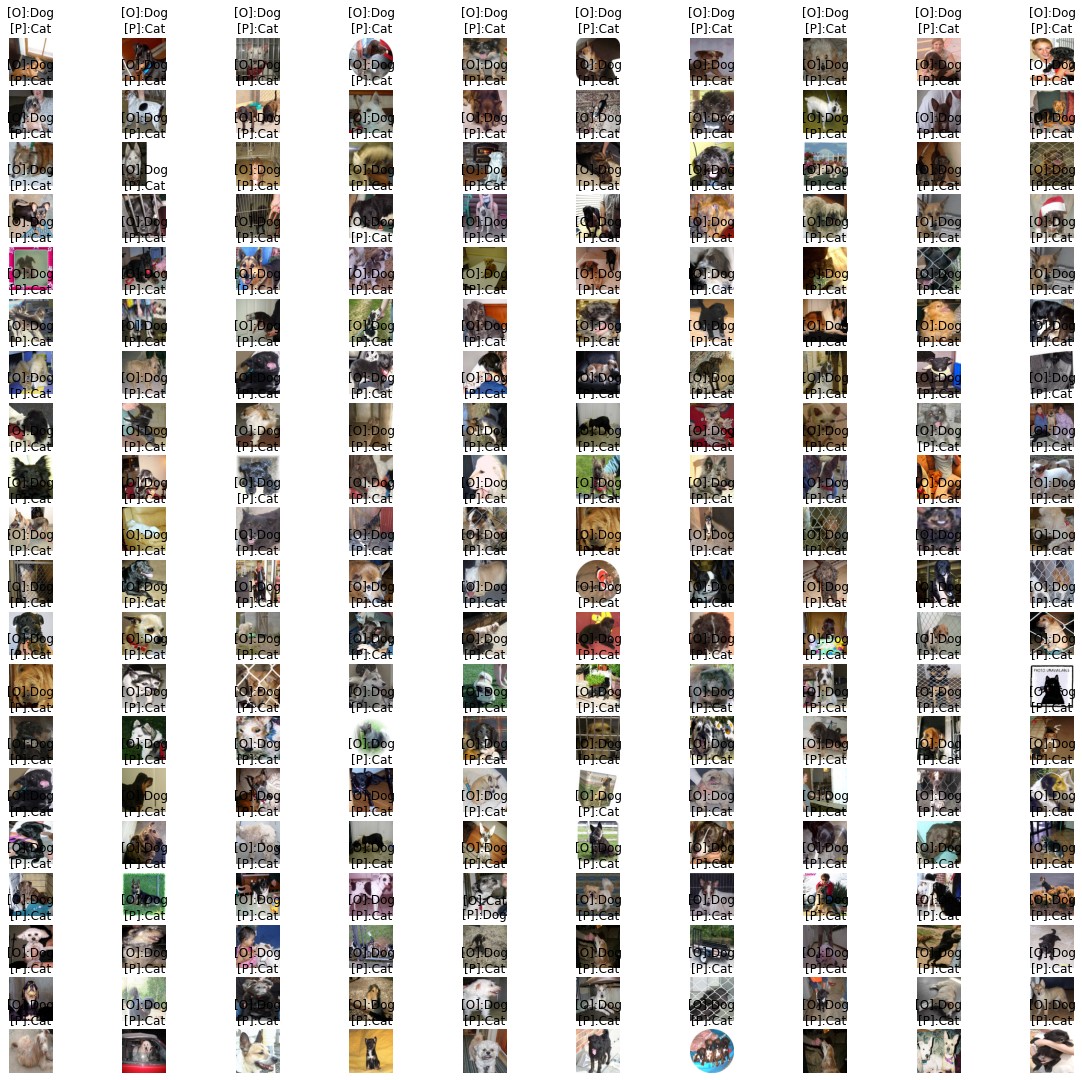

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

pre = model.predict_classes(x_batch)
trans = ["Dog", "Cat"]
idx = np.nonzero(pre != y_batch)[0][:200]
false_img = x_batch_ori[idx]
false_pre = pre[idx]
false_label = y_batch[idx]
plt.figure(figsize=(20, 20))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[false_label[i]], trans[false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(false_img[i])

url:https://www.cdc.gov/healthypets/images/pets/cute-dog-headshot.jpg


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dog 的機率: 1.0
Cat 的機率: 0.0
答案: Dog


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


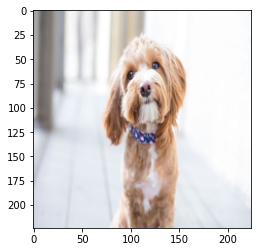

In [ ]:

# Pillow
import requests
from PIL import Image
# RGB, RGBA, L(gray)
url = input("url:")
headers = {
  "user-agent":"user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36"  
}
response = requests.get(url, headers=headers, stream=True, verify=False)
img = Image.open(response.raw).resize((224, 224)).convert("RGB")
img_np = np.array(img)
img_np_r = preprocess_input(img_np.reshape(1, 224, 224, 3))
proba = model.predict(img_np_r)[0]
for i, p in enumerate(proba):
    print(trans[i], "的機率:", p)
ans = model.predict_classes(img_np_r)[0]
print("答案:", trans[ans])
plt.imshow(img_np)